### Convolutional Autoencoder 
Implemnted with helper functions on data collection, training, test, plotting, and evaluation. Important helper functions are not imported here. 

In [1]:
import torch 
import matplotlib.pyplot as plt 

utlity functions import

In [2]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels

In [3]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


Hyperparameters

In [4]:
RANDOM_SEED= 123 
LEARNING_RATE= 0.0005 
BATCH_SIZE=32 
NUM_EPOCHS= 20 

set_deterministic
set_all_seeds(RANDOM_SEED)  #set random seed so we can reproduce the 

Load data from the helper functions 

MNIST dataset, input is a 28x28 grayscale image. We don't get any validation set  
$$x \in \mathbb{R}^{28 \times 28} \: f(x) \in \mathbb{R}^{batch\_size \times 1} \: y \in \mathbb{R}^{batch\_size \times 1}$$

In [5]:
train_loader, valid_loader, test_loader= get_dataloaders_mnist(
    batch_size= BATCH_SIZE, num_workers= 2, validation_fraction=0)

print("Training set:\n")
for images, labels in train_loader:
    print(f"Image batch dimension: {images.size()}")
    print(f"Image label dimension: {labels.size()}")
    print(labels[:10])
    break 

print("\nValidation set:")
for images, labels in valid_loader:
    print(f"Image batch dimension: {images.size()}")
    print(f"Image label dimension: {labels.size()}")
    print(labels[:10])
    break 

print("\nTest set:")
for images, labels in test_loader:
    print(f"Image batch dimension: {images.size()}")
    print(f"Image label dimension: {labels.size()}")
    print(labels[:10])
    break 

Training set:

Image batch dimension: torch.Size([32, 1, 28, 28])
Image label dimension: torch.Size([32])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation set:

Test set:
Image batch dimension: torch.Size([32, 1, 28, 28])
Image label dimension: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


### Model 
- autoencoder to reduce to smaller dimensions in the latent space using CNN
- Transposed Convolution to projcet back to the original dimension

To determine the output dimension of transpose convolution, we use  
(I-1) x S - 2P + K +output_padding(default 0)

In [6]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape= args 
    def forward(self,x):
        return x.view(self.shape)   #reshape 

class Trim(torch.nn.Module):
    def __init__(self, *args):
        super().__init__()
    def forward(self, x):
        return x [:,:,:28,:28]  #return the first 28 elements of dimension 3 and 4 

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= torch.nn.Sequential(  #our input size is 28x28=784
                torch.nn.Conv2d(1,32,stride=(1,1),kernel_size=(3,3),padding=1), #conv layer 28x28x32
                torch.nn.LeakyReLU(0.01),
                torch.nn.Conv2d(32,64,stride=(2,2), kernel_size=(3,3), padding=1),  #14x14x64
                torch.nn.LeakyReLU(0.01),
                torch.nn.Conv2d(64,64,stride=(2,2), kernel_size=(3,3), padding=1),  #7x7x64
                torch.nn.LeakyReLU(0.01),
                torch.nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),  #7x7x64
                torch.nn.Flatten(),  #flatten into a single vector 1x3136
                torch.nn.Linear(3136,2) #linear transformation to project all to latent space  output: 1x2  
        )
        #encoder starts with a 784 sized vector down to 2 dimensional representation through CNN and linear transformation (like usual autoencoder)

        self.decoder= torch.nn.Sequential(
                torch.nn.Linear(2,3136), #project back to the input dimension
                Reshape(-1,64,7,7),  #reshape the output 1 x 64 x 7 x 7, 64 channels of 7 x 7 input
                torch.nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3), padding= 1), #keep same channels and expand the input through transpose convolution. Same dimension
                torch.nn.LeakyReLU(0.01),   #non-linear transformation after every transpose convolution
                torch.nn.ConvTranspose2d(64,64,stride=(2,2), kernel_size=(3,3),padding=1),  #same channel, and expand the input even more. 1 x 64 x 13 x 13
                torch.nn.LeakyReLU(0.01),   #continue scaling 
                torch.nn.ConvTranspose2d(64,32,stride=(2,2), kernel_size=(3,3), padding=0), # scale down to 32 channels, 1 x 32 x 27 x 27
                torch.nn.LeakyReLU(0.01),
                torch.nn.ConvTranspose2d(32,1,stride= (1,1), kernel_size=(3,3), padding=0), #revert back to 1 x 1 x 29 x 29
                Trim(),     #1x 29 x 29 -> 1 x 28 x 28 take the first 28 pixels of the output. Back to the same dimension and channel of the original input
                torch.nn.Sigmoid()
        )
    def forward(self, img):
        img= self.encoder(img)
        img= self.decoder(img)
        return img


In [7]:
set_all_seeds(RANDOM_SEED)  #ensure random weights are generated the same everytime we run 
model= AutoEncoder() 
model.to(DEVICE)    #send to CUDA for processing 
optimizer= torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)   #default using Adam with model's parameters and learning rate

### Training 

In [9]:
log_output= train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model, optimizer=optimizer,
                                 device= DEVICE, train_loader=train_loader, skip_epoch_stats=True, 
                                 logging_interval=250
                                 )

Epoch: 001/020 | Batch 0000/1875 | Loss: 0.2996
Epoch: 001/020 | Batch 0250/1875 | Loss: 0.0615
Epoch: 001/020 | Batch 0500/1875 | Loss: 0.0567
Epoch: 001/020 | Batch 0750/1875 | Loss: 0.0500
Epoch: 001/020 | Batch 1000/1875 | Loss: 0.0499
Epoch: 001/020 | Batch 1250/1875 | Loss: 0.0517
Epoch: 001/020 | Batch 1500/1875 | Loss: 0.0467
Epoch: 001/020 | Batch 1750/1875 | Loss: 0.0443
Time elapsed: 0.46 min
Epoch: 002/020 | Batch 0000/1875 | Loss: 0.0485
Epoch: 002/020 | Batch 0250/1875 | Loss: 0.0471
Epoch: 002/020 | Batch 0500/1875 | Loss: 0.0475
Epoch: 002/020 | Batch 0750/1875 | Loss: 0.0446
Epoch: 002/020 | Batch 1000/1875 | Loss: 0.0441
Epoch: 002/020 | Batch 1250/1875 | Loss: 0.0468
Epoch: 002/020 | Batch 1500/1875 | Loss: 0.0418
Epoch: 002/020 | Batch 1750/1875 | Loss: 0.0499
Time elapsed: 0.93 min
Epoch: 003/020 | Batch 0000/1875 | Loss: 0.0433
Epoch: 003/020 | Batch 0250/1875 | Loss: 0.0468
Epoch: 003/020 | Batch 0500/1875 | Loss: 0.0440
Epoch: 003/020 | Batch 0750/1875 | Loss: 0

### Evaluation through plotting outputs 

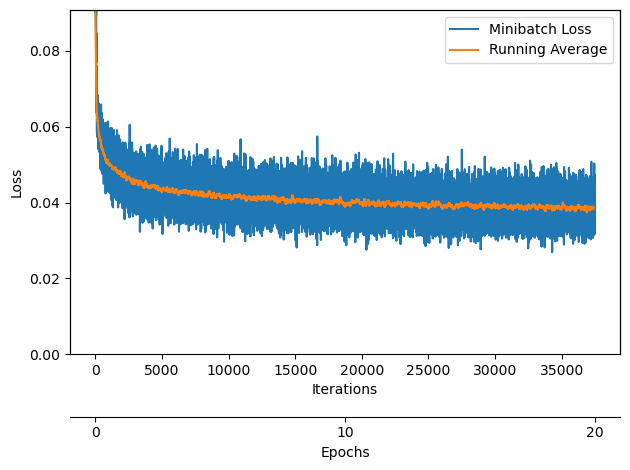

In [12]:
plot_training_loss(log_output['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

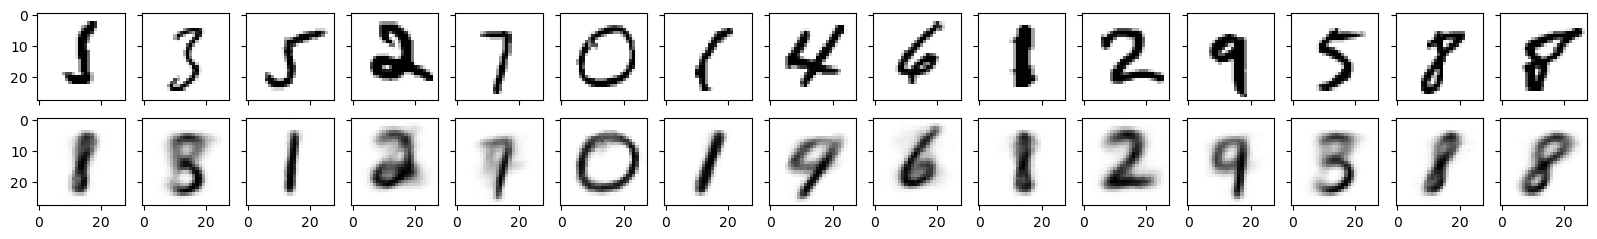

In [13]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)

#lower representation (smaller latent space) makes the output images more blurry. 
# for better reconstructions, we need to increase the latent space dimensions
# also makes mistakes 

### Latent Space
Visualization of the 2 dimension classes. 
- Each legend corresponds to a number. Autoencoder captures the number's similarities despite a low dimensional representation   
- Information maybe lost because the number is overlapped (4 is reconstructed as a 9)--> solved by variational autoencoder  
- Both axises represent the value of the tensor. Corresponding tensor will have the output  
- This space is not representative of all the possibilities. it's constructed using the encoder of the training set, and plot corresponding number with the tensors the model reduced to after training 

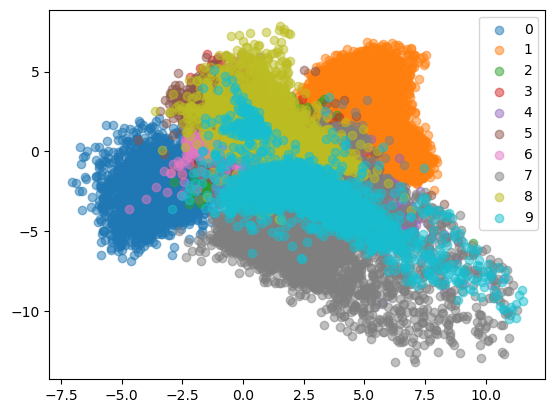

In [15]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader= train_loader,
    model=model,
    device=DEVICE
)
plt.legend()
plt.show()

### Reconstruction 
After training, our model has learned to reconstruct from a 2 dimension latent space (2 dimension vector) into 28 x 28 image. 

We test this reconstruction by randomly giving it a two dimension tensor. Different values will create different tensors (based on the representation graph above)

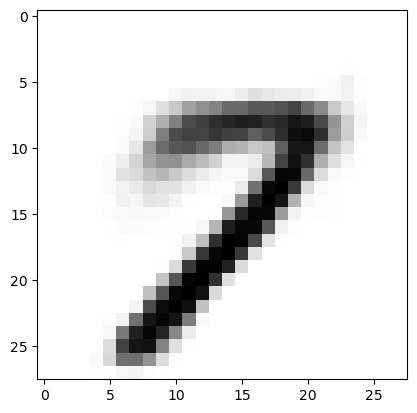

In [22]:
with torch.no_grad(): 
    output= model.decoder(torch.tensor([7.5,-10.0]).to(DEVICE))
    output.squeeze_(0)
    output.squeeze_(0)
plt.imshow(output.to('cpu').numpy(),cmap="binary")
plt.show() 